In [1]:
import functools
import itertools
import logging
import math
import os
import pickle
import sys
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns
import yaml

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_context("poster")
sns.set(rc={"figure.figsize": (16, 12.0)})
sns.set_style("whitegrid")

import numpy as np
import pandas as pd
import torch.nn.functional as F

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
from lda4rec.datasets import Interactions, DataLoader, random_train_test_split
from lda4rec.evaluations import mrr_score, precision_recall_score,summary
from lda4rec.estimators import MFEst, PopEst, LDA4RecEst, SNMFEst
from lda4rec.utils import process_ids, cmp_ranks

In [3]:
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import torch
from pyro.distributions import constraints
from pyro.infer import SVI, Predictive, Trace_ELBO, TraceEnum_ELBO, config_enumerate

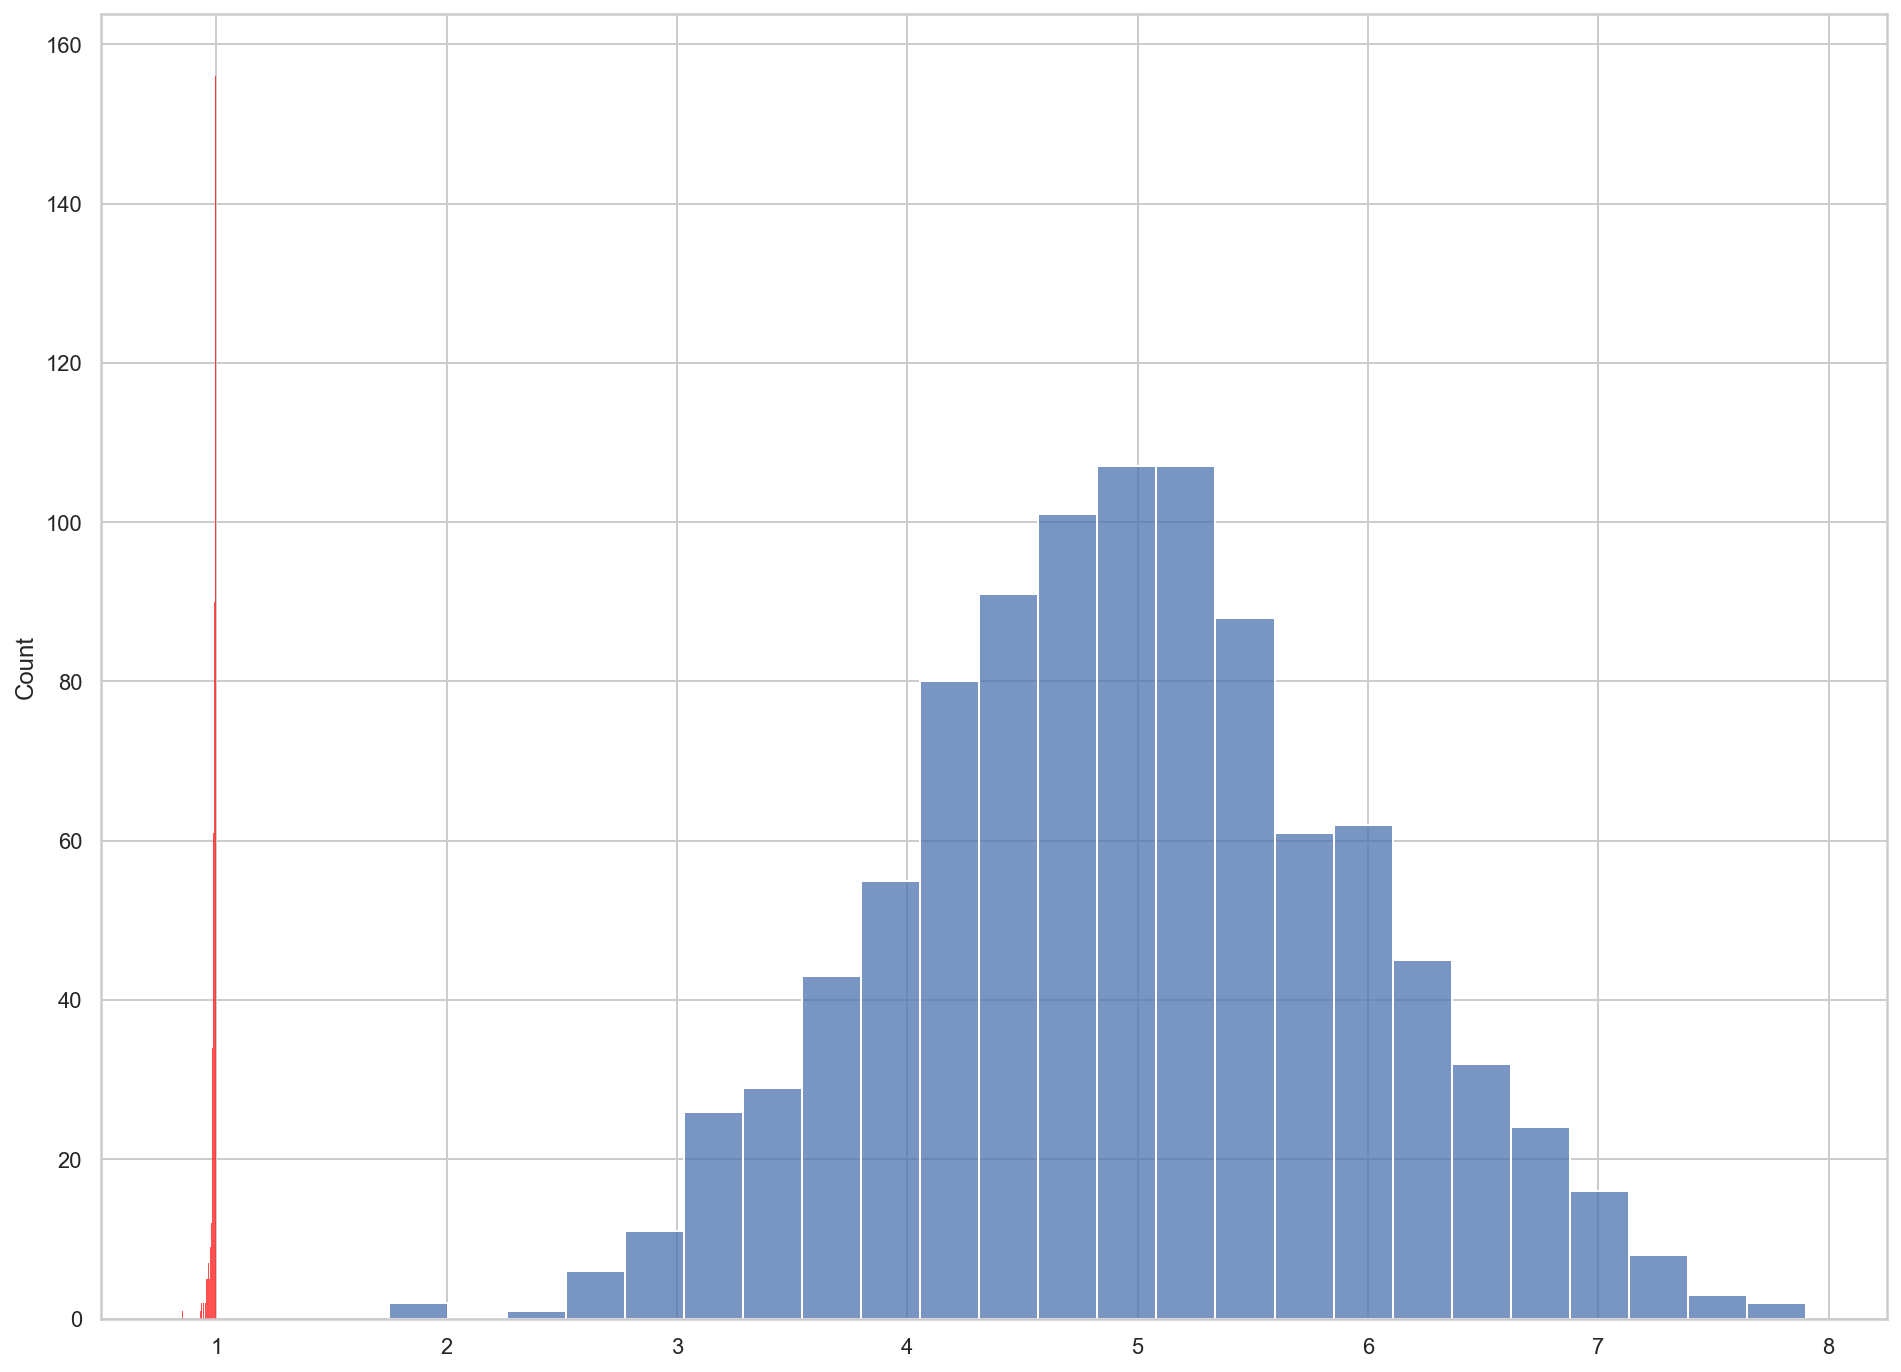

In [25]:
a = dist.Normal(5.,1.).sample((1000,))
b = torch.sigmoid(a)
sns.histplot(a)
sns.histplot(b, color='red')
plt.show()

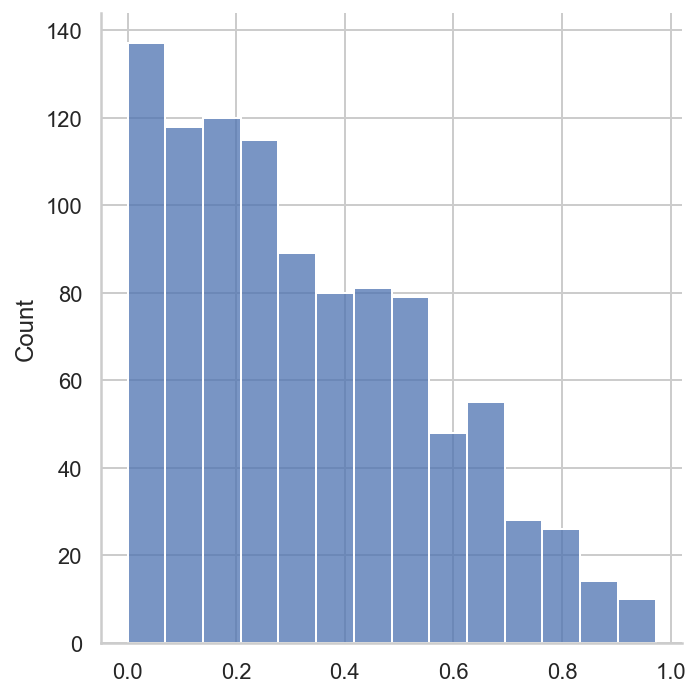

In [33]:
a=dist.Beta(1, 2).sample((1000,))
sns.displot(a)                       

## ToDos:

* Allow training on new cold-start users, i.e. fix the parameters after a training on items. Split Data into Warm-Train, Cold-Train and Cold-Test. Flow:
  1. Train on Warm-Training Dataset like usual (all parameters are learned)
  2. Train on Cold-Train having selected users (item parameters are fixed but user params are still learned)
  3. Test on Cold-Test for those users.
  
  This is the protocol as described in https://www.ijcai.org/Proceedings/15/Papers/559.pdf. First implement in the estimators the logic for doing the trainings, then the evaluation protocol. This needs to be done for classical MF and LDA4Rec.
* [Optional] If it helps use rankeval and replace the functionality in `evaluations.py` with it as it is more standard conform to other papers 
* Build the hierarchical model in `models.py` that should be more efficient than MF and even LDA4Rec.

In [4]:
import neptune.new as neptune
# init dummy neptune to avoid problems with logging
neptune.init(mode='offline') 

offline/80251bda-7918-481a-8a30-9bba654e0144
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [5]:
from icecream import ic, install

install()
# configure icecream
def ic_str(obj):
    if hasattr(obj, "shape"):
        return f"{obj} "  #
    else:
        return str(obj)

In [6]:
ic.configureOutput(argToStringFunction=ic_str)

## Experimenting with different estimators

In [7]:
loader = DataLoader()
data = loader.load_movielens("100k")

In [8]:
max_interactions = 200
data.max_user_interactions_(max_interactions)

In [9]:
data.implicit_(0.)
train, test = random_train_test_split(data)

In [10]:
pop_est = PopEst()
pop_est.fit(train)

In [11]:
summary(pop_est, train=train, test=test)

,train,test
metric,,
prec,0.291803,0.102131
recall,0.054558,0.070099
mrr,0.026414,0.034170


In [12]:
mf_est = MFEst(embedding_dim=4, n_iter=30)
mf_est.fit(train)

INFO:lda4rec.estimators:Epoch     0: loss 0.404354583572697
INFO:lda4rec.estimators:Epoch     1: loss 0.20797650340843846
INFO:lda4rec.estimators:Epoch     2: loss 0.13986891578580882
INFO:lda4rec.estimators:Epoch     3: loss 0.11727773990180042
INFO:lda4rec.estimators:Epoch     4: loss 0.10805735243736087
INFO:lda4rec.estimators:Epoch     5: loss 0.09847212079409007
INFO:lda4rec.estimators:Epoch     6: loss 0.0937124301352211
INFO:lda4rec.estimators:Epoch     7: loss 0.08905262555423621
INFO:lda4rec.estimators:Epoch     8: loss 0.08660830796469708
INFO:lda4rec.estimators:Epoch     9: loss 0.08231331591267843
INFO:lda4rec.estimators:Epoch    10: loss 0.07808830114333211
INFO:lda4rec.estimators:Epoch    11: loss 0.07794187040244405
INFO:lda4rec.estimators:Epoch    12: loss 0.07646078194516737
INFO:lda4rec.estimators:Epoch    13: loss 0.07677068473720873
INFO:lda4rec.estimators:Epoch    14: loss 0.07273450049294813
INFO:lda4rec.estimators:Epoch    15: loss 0.07077608461919668
INFO:lda4re

0.06207328474249792

In [13]:
summary(mf_est, train=train, test=test)

,train,test
metric,,
prec,0.290984,0.110328
recall,0.052997,0.071499
mrr,0.027704,0.034825


In [41]:
lda_est = LDA4RecEst(embedding_dim=4, n_iter=2_000, batch_size=128, learning_rate=0.001, use_jit=True)

In [45]:
model_state = "../models/param.state"
if Path(model_state).is_file():
    lda_est.load(model_state)
else:
    lda_est.fit(train)
    lda_est.save(model_state)

In [49]:
lda_est.predict_posterior = False
summary(lda_est, train=train, test=test)

,train,test
metric,,
prec,0.216721,0.073443
recall,0.038625,0.046652
mrr,0.019233,0.020335


In [ ]:
lda_est.predict_posterior = True
summary(lda_est, train=train, test=test)

(0.0, 5.0)

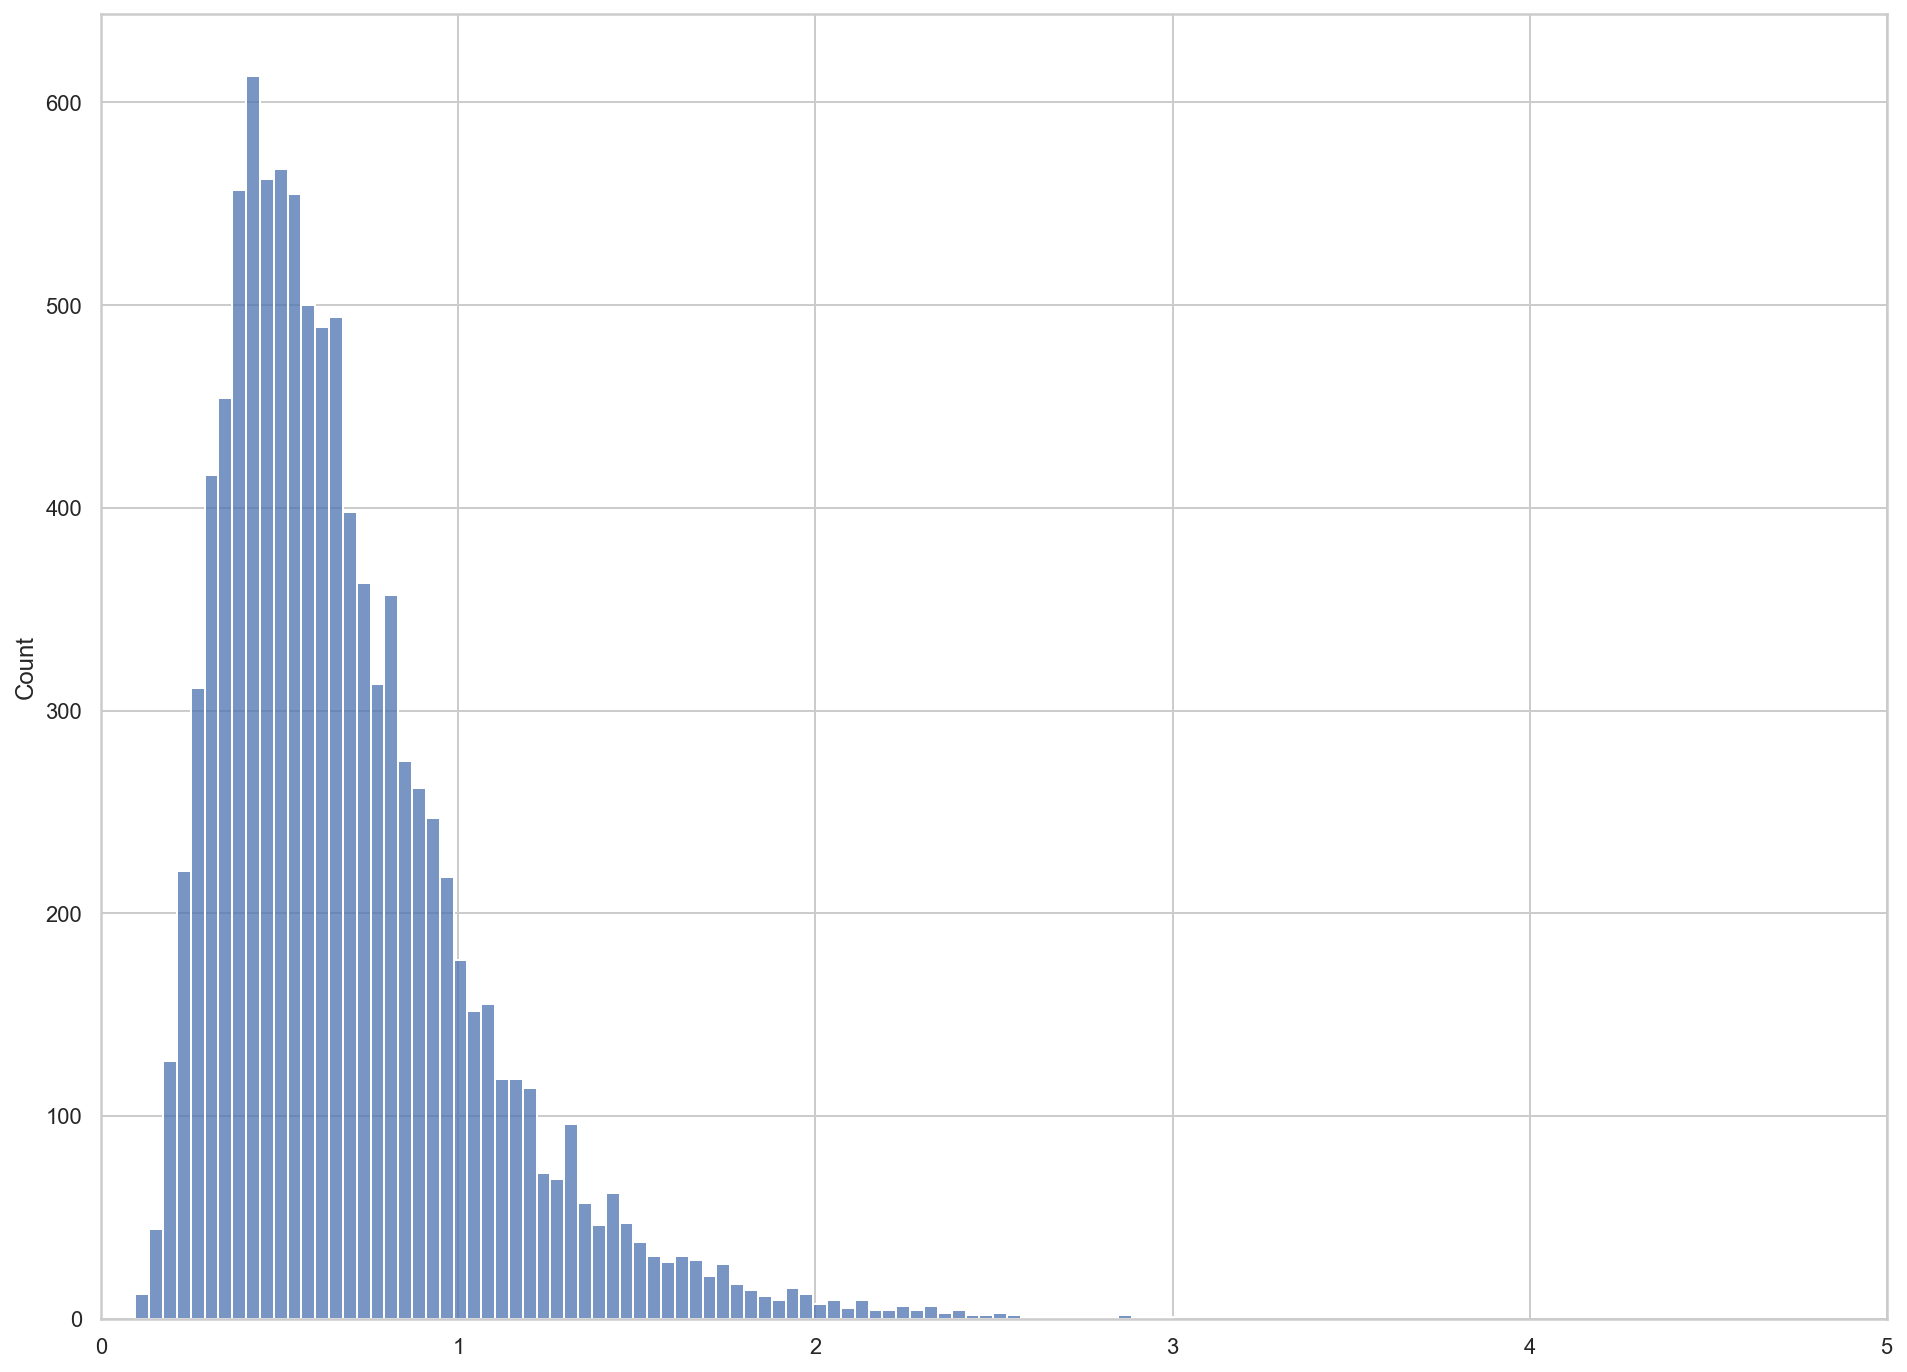

In [84]:
sns.histplot(dist.LogNormal(-0.5,0.5).sample((10_000,)))
plt.xlim(0, 5)

In [55]:
np.exp(-0.5)

0.6065306597126334

In [24]:
torch.rand(torch.bincount(torch.arange(10)).shape)

tensor([0.1223, 0.3370, 0.8262, 0.8811, 0.8574, 0.0309, 0.0379, 0.9681, 0.5868,
        0.8301])

In [42]:
lda_est.user_pop_devs.shape

NameError: name 'lda_est' is not defined

In [52]:
lda_est.user_pop_devs.shape

torch.Size([610])

## Matrix Factorization as aLDA formulation

In [706]:
user_id = 128
orig_scores = mf_est.predict(np.array([user_id], dtype=np.int))
item_probs = mf_est.get_item_probs(user_id)

In [707]:
cmp_ranks(orig_scores, item_probs, eps=1e-5)

True

In [708]:
torch.where

<function _VariableFunctionsClass.where>

In [709]:
np.sum(np.argsort(orig_scores) != np.argsort(item_probs))

8

In [710]:
torch.min(torch.eye(10), dim=0)

torch.return_types.min(
values=tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
indices=tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [711]:
torch.zeros(1).shape

torch.Size([1])

In [712]:
torch.min(torch.arange(10)-1.).shape

torch.Size([])

In [713]:
torch.zeros(0)

tensor([])

In [60]:
n_samples = 200
rng = np.random.default_rng(42)
model_params["interactions"] = data.interactions

predictive = Predictive(model, guide=guide, num_samples=n_samples)
samples = {
    k: v.detach().cpu().numpy()
    for k, v in predictive(**model_params).items()
}

IndexError: index 1 is out of bounds for dimension 0 with size 1